Размер таблицы: (10000, 12)
Наша цель (что предсказываем): pm2.5
Используемые признаки: ['pm10', 'no2', 'so2', 'co', 'o3', 'temperature', 'humidity', 'wind speed']

Качество модели:
MAE : 36.252266950000006
RMSE: 42.39070571074354


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


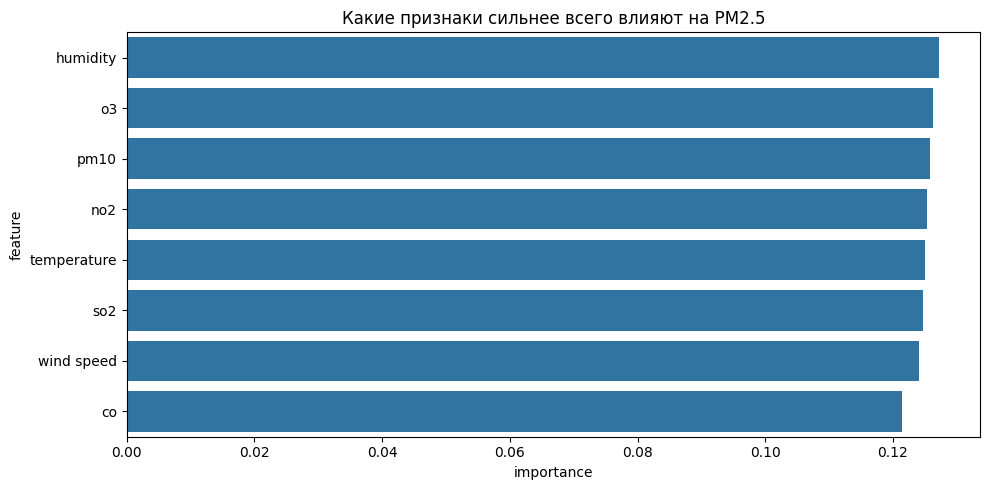

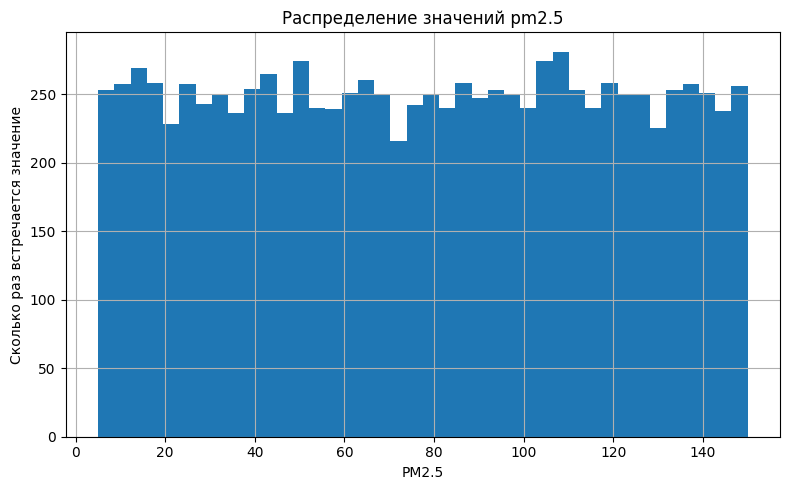

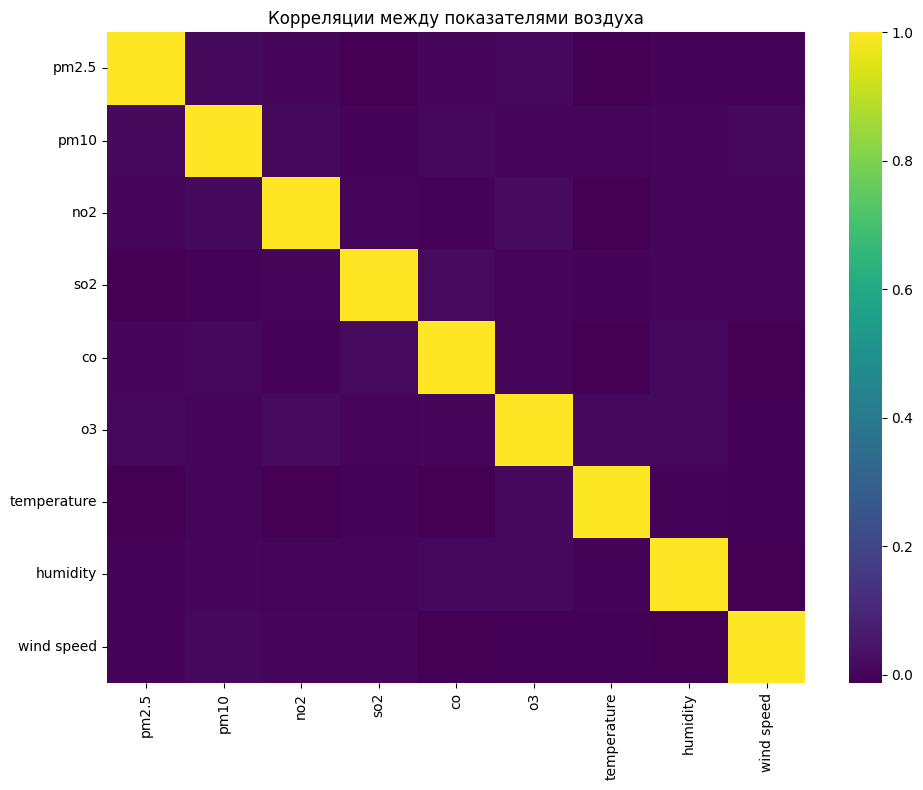

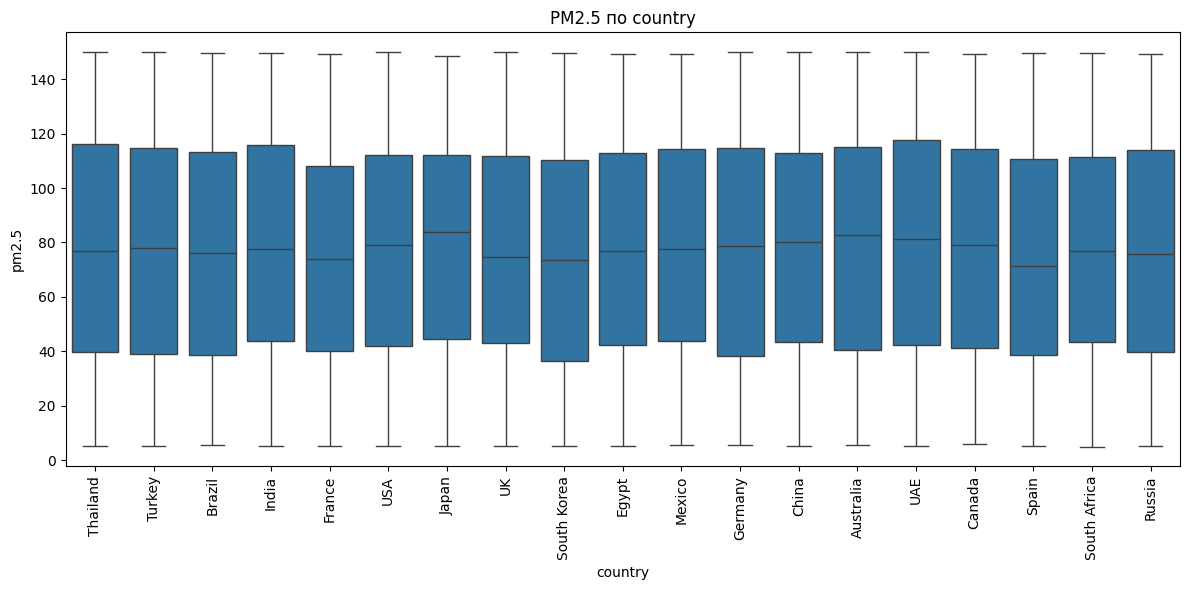

In [7]:
# =============================================================
# GLOBAL AIR QUALITY — FULL EDA + MODEL (с простыми объяснениями)
# =============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# =============================================================
# 1. Загрузка данных
# =============================================================
# Здесь мы загружаем наш CSV по ссылке.
# Это наш исходный набор данных, с которым будем работать.
csv_url = "global_air_quality_data_10000 3.csv"  
df = pd.read_csv(csv_url)

# Приводим названия колонок к нижнему регистру, чтобы не путаться
df.columns = [c.lower().strip() for c in df.columns]

print("Размер таблицы:", df.shape)
df.head()


# =============================================================
# 2. Определяем целевую переменную (PM2.5)
# =============================================================
# Мы ищем колонку, где содержится показатель PM2.5 —
# это главный загрязнитель воздуха, который вреден для здоровья.
# Именно его мы будем пытаться предсказывать.
target_candidates = ["pm2.5", "pm25", "pm_2_5"]
target = None

for c in target_candidates:
    if c in df.columns:
        target = c
        break

if target is None:
    raise ValueError("Не нашли PM2.5. Посмотри названия столбцов.")

print("Наша цель (что предсказываем):", target)


# =============================================================
# 3. Первичная очистка данных
# =============================================================
# Удаляем строки, где PM2.5 отсутствует — предсказывать нечего.
df = df.dropna(subset=[target])

# Берём только числовые признаки — модели нужна числовая информация.
numeric_df = df.select_dtypes(include=np.number)

# Признаки для обучения — все числовые столбцы, кроме самого PM2.5
features = [c for c in numeric_df.columns if c != target]

# Заполняем пропуски медианой — безопасный способ, чтобы не ломать данные.
df[features] = df[features].fillna(df[features].median())

print("Используемые признаки:", features)


# =============================================================
# 4. Разделение данных на обучение и тест
# =============================================================
# 80% данных — обучение, 20% — тестирование, чтобы проверить, насколько хорошо модель работает.
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# =============================================================
# 5. Создание модели: масштабирование + Random Forest
# =============================================================
# RandomForest — хорошая модель для экологических данных:
# устойчива к шуму, не требует сложной подготовки.
model = Pipeline([
    ("scaler", StandardScaler()),  # приводит признаки к единому масштабу
    ("rf", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)
preds = model.predict(X_test)

# Метрики качества — чем ниже, тем лучше
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)

print("\nКачество модели:")
print("MAE :", mae)
print("RMSE:", rmse)


# =============================================================
# 6. Feature Importance — важность признаков
# =============================================================
# Этот график показывает, какие именно факторы больше всего
# влияют на уровень PM2.5.
rf = model.named_steps["rf"]
importances = rf.feature_importances_

fi = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=fi, x="importance", y="feature")
plt.title("Какие признаки сильнее всего влияют на PM2.5")
plt.tight_layout()
plt.show()

# Пояснение:
# Если наверху NO2, CO или SO2 — это значит, что сильный вклад в загрязнение
# дают выхлопы транспорта и промышленные выбросы.
# Если важны влажность/температура — погода тоже играет роль.


# =============================================================
# 7. Распределение PM2.5 — гистограмма
# =============================================================
plt.figure(figsize=(8, 5))
df[target].hist(bins=40)
plt.title(f"Распределение значений {target}")
plt.xlabel("PM2.5")
plt.ylabel("Сколько раз встречается значение")
plt.tight_layout()
plt.show()

# Пояснение:
# Гистограмма показывает, как часто встречаются разные уровни загрязнения.
# Если большинство значений маленькие, но есть редкие большие —
# значит бывают эпизоды сильного смога.
# Если много высоких значений — в регионе постоянная проблема с качеством воздуха.


# =============================================================
# 8. Матрица корреляций
# =============================================================
plt.figure(figsize=(10, 8))
corr = numeric_df.corr()
sns.heatmap(corr, cmap="viridis", annot=False)
plt.title("Корреляции между показателями воздуха")
plt.tight_layout()
plt.show()

# Пояснение:
# Корреляции показывают, какие загрязнители растут вместе.
# Например, если PM2.5 сильно связан с CO — это признак,
# что оба загрязнения часто идут от транспорта или сжигания топлива.


# =============================================================
# 10. Boxplot по странам/городам (если такие столбцы есть)
# =============================================================
possible_group_cols = ["country", "city", "location"]

for col in possible_group_cols:
    if col in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x=col, y=target)
        plt.xticks(rotation=90)
        plt.title(f"PM2.5 по {col}")
        plt.tight_layout()
        plt.show()

        # Пояснение:
        # Такой график показывает различия между городами/странами.
        # Где медиана выше — там воздух хуже в среднем.
        # Если «усы» длинные — бывают редкие, но сильные эпизоды загрязнения.
        break


        # Пояснение:
        # По точкам можно понять, связан ли PM2.5 с другими загрязнителями.
        # Если точки тянутся вверх — чем больше газа, тем больше PM2.5.
        # Это говорит, что источники загрязнения совпадают.


# =============================================================
# Конец отчёта
# =============================================================
